# Evolutionary algorithm implemented in Python

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import pyplot as plt
import math
import random

## Case study
Find the maximum: 
$\begin{equation}
f(x, y) = 0.5 - \frac{\textrm{sin}^2\sqrt{x^2 + y^2} - 0.5}{1 + 0.001(x^2 + y^2)^2}
\end{equation}$

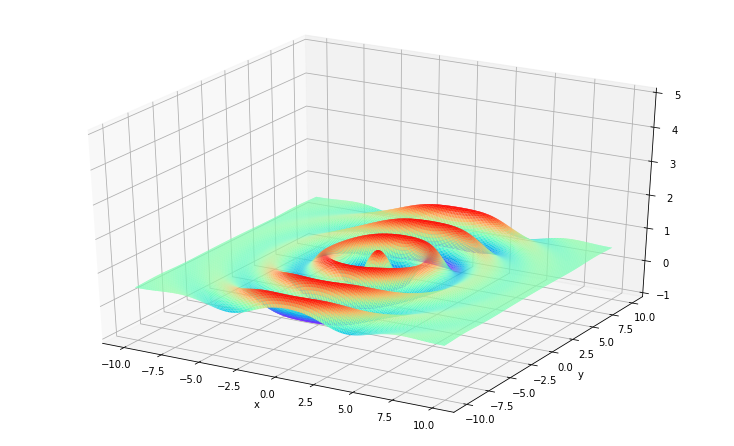

In [2]:
fig = plt.figure(figsize = (10, 6))
ax = Axes3D(fig)
x = np.arange(-10, 10, 0.1)
y = np.arange(-10, 10, 0.1)
X, Y = np.meshgrid(x, y)
Z = 0.5 - (np.sin(np.sqrt(X**2 + Y**2))**2 -0.5)/(1 + 0.001*(x**2 + y**2)**2)
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlim([-1, 5])
ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = 'rainbow')
plt.show()

## Evolutionary algorithm

In [3]:
class Population:
    
    
    def __init__(self, size, chrom_size, cp, mp, gen_max):
        self.individuals = []
        self.fitness = []
        self.selector_probability = []
        self.new_individuals = []
        self.elitist = {'chromosome': [0, 0], 'fitness': 0, 'age': 0}
        self.size = size
        self.chromosome_size = chrom_size
        self.crossover_probability = cp
        self.mutation_probability = mp
        self.generation_max = gen_max
        self.age = 0
        
        # Initialization
        v = 2 ** self.chromosome_size - 1
        for i in range(self.size):
            self.individuals.append([random.randint(0, v), random.randint(0, v)])
            self.new_individuals.append([0, 0])
            self.fitness.append(0)
            self.selector_probability.append(0)
            
            
    def decode(self, interval, chromosome):
        d = interval[1] - interval[0]
        n = float(2**self.chromosome_size - 1)
        return (interval[0] + chromosome * d / n)
    
    
    def fitness_func(self, chrom1, chrom2):
        interval = [-10.0, 10.0]
        (x, y) = (self.decode(interval, chrom1), self.decode(interval, chrom2))
        n = lambda x, y: math.sin(math.sqrt(x*x + y*y))**2 - 0.5
        d = lambda x, y: (1 + 0.001*(x*x + y*y))**2
        func = lambda x, y: 0.5 - n(x, y) / d(x, y)
        return func(x, y)
    
    
    def evaluate(self):
        sp = self.selector_probability
        
        for i in range(self.size):
            self.fitness[i] = self.fitness_func(self.individuals[i][0], self.individuals[i][1])
            
        ft_sum = sum(self.fitness)
        
        for i in range(self.size):
            sp[i] = self.fitness[i] / float(ft_sum)
            
        for i in range(1, self.size):
            sp[i] = sp[i] + sp[i-1]
        
        
    def select(self):
        (t, i) = (random.random(), 0)
        for p in self.selector_probability:
            if p > t:
                break
            i = i + 1
        return i
    
    
    def cross(self, chrom1, chrom2):
        p = random.random()
        n = 2**self.chromosome_size - 1
        
        if chrom1 != chrom2 and p < self.crossover_probability:
            t = random.randint(1, self.chromosome_size - 1)
            mask = n << t
            (r1, r2) = (chrom1 & mask, chrom2 & mask)
            mask = n >> (self.chromosome_size - t)
            (l1, l2) = (chrom1 & mask, chrom2 & mask)
            (chrom1, chrom2) = (r1 + l2, r2 + l1)
        
        return (chrom1, chrom2)
    
    
    def mutate(self, chrom):
        p = random.random()
        
        if p < self.mutation_probability:
            t = random.randint(1, self.chromosome_size)
            mask1 = 1 << (t-1)
            mask2 = chrom & mask1
            
            if mask2 > 0:
                chrom = chrom & (~mask2)
            else:
                chrom = chrom ^ mask1
                
        return chrom
    
    
    def reproduct_elitist(self):
        j = -1
        
        for i in range(self.size):
            if self.elitist['fitness'] < self.fitness[i]:
                j = i
                self.elitist['fitness'] = self.fitness[i]
                
        if (j >= 0):
            self.elitist['chromosome'][0] = self.individuals[j][0]
            self.elitist['chromosome'][1] = self.individuals[j][1]
            self.elitist['age'] = self. age
            
            
    def evolve(self):
        indvs = self.individuals
        new_indvs = self.new_individuals
        
        self.evaluate()
        
        i = 0
        
        while True:
            # Selecttion
            idv1 = self.select()
            idv2 = self.select()
            
            #Crossover
            (idv1_x, idv1_y) = (indvs[idv1][0], indvs[idv1][1])
            (idv2_x, idv2_y) = (indvs[idv2][0], indvs[idv2][1])
            
            (idv1_x, idv2_x) = self.cross(idv1_x, idv2_x)
            (idv1_y, idv2_y) = self.cross(idv1_y, idv2_y)
            
            # Mutation
            (idv1_x, idv1_y) = (self.mutate(idv1_x), self.mutate(idv1_y))
            (idv2_x, idv2_y) = (self.mutate(idv2_x), self.mutate(idv2_y))
            (new_indvs[i][0], new_indvs[i][1]) = (idv1_x, idv1_y)
            (new_indvs[i+1][0], new_indvs[i+1][1]) = (idv2_x, idv2_y)
            
            i = i + 2
            
            if i >= self.size:
                break
                
        self.reproduct_elitist()
        
        for i in range(self.size):
            self.individuals[i][0] = self.new_individuals[i][0]
            self.individuals[i][1] = self.new_individuals[i][1]
            
            
    def run(self):
        for i in range(self.generation_max):
            self.evolve()
            print(i, round(max(self.fitness), 3), round(sum(self.fitness)/self.size, 3), round(min(self.fitness), 3))

## Test

In [4]:
if __name__ == '__main__':
    pop = Population(100, 25, 0.8, 0.1, 200)
    pop.run()

0 0.96 0.462 0.024
1 0.99 0.637 0.005
2 0.963 0.738 0.062
3 0.984 0.75 0.002
4 0.969 0.762 0.015
5 0.987 0.817 0.165
6 0.989 0.81 0.019
7 0.989 0.794 0.011
8 0.979 0.828 0.007
9 0.979 0.74 0.069
10 0.987 0.833 0.254
11 0.988 0.822 0.033
12 0.989 0.822 0.044
13 0.982 0.803 0.004
14 0.99 0.782 0.04
15 0.99 0.769 0.104
16 0.99 0.806 0.057
17 0.99 0.814 0.015
18 0.99 0.806 0.022
19 0.99 0.815 0.057
20 0.99 0.833 0.065
21 0.99 0.83 0.108
22 0.99 0.801 0.008
23 0.99 0.794 0.033
24 0.99 0.795 0.032
25 0.99 0.785 0.118
26 0.99 0.841 0.014
27 0.99 0.9 0.361
28 0.99 0.872 0.064
29 0.99 0.825 0.059
30 0.99 0.878 0.01
31 0.99 0.888 0.081
32 0.99 0.901 0.145
33 0.99 0.849 0.119
34 0.99 0.852 0.04
35 0.99 0.855 0.004
36 0.99 0.862 0.007
37 0.99 0.858 0.021
38 0.99 0.893 0.073
39 0.99 0.881 0.024
40 0.99 0.854 0.004
41 0.99 0.853 0.071
42 0.99 0.87 0.057
43 0.99 0.883 0.544
44 0.99 0.863 0.172
45 0.99 0.882 0.237
46 0.99 0.884 0.004
47 0.99 0.9 0.104
48 0.99 0.855 0.029
49 0.99 0.857 0.022
50 0.989 0